<a href="https://colab.research.google.com/github/offline0x33/Projeto-de-Transfer-Learning-em-Python/blob/main/tranferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import matplotlib.pyplot as plt
import requests
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model


In [2]:

def download_file(url, filename):
  """Baixa um arquivo da URL especificada e salva com o nome fornecido.

  Args:
    url: A URL do arquivo a ser baixado.
    filename: O nome do arquivo de saída.
  """

  response = requests.get(url, stream=True, verify=False)

  if response.status_code == 200:
    with open(filename, 'wb') as f:
      for chunk in response.iter_content(1024):
        if chunk:  # filter out keep-alive new chunks
          f.write(chunk)
    print(f"Arquivo baixado com sucesso: {filename}")
  else:
    print(f"Falha ao baixar o arquivo: {response.status_code}")

# URL e nome do arquivo
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
filename = "/tmp/cats-and-dogs.zip"

# Chamando a função para baixar o arquivo
download_file(url, filename)

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.microsoft.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Arquivo baixado com sucesso: /tmp/cats-and-dogs.zip
12501
12501


In [3]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass


In [4]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename

    copyfile(this_file, destination)

In [5]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.
11250
11250
1250
1250


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,470,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

history = model.fit(train_generator,
                              epochs=15,
                              steps_per_epoch=90,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=6)

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.5276 - loss: 0.7475 - val_accuracy: 0.7150 - val_loss: 0.6145
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.6566 - loss: 0.6222 - val_accuracy: 0.7767 - val_loss: 0.5447
Epoch 3/15
14/90 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - accuracy: 0.6896 - loss: 0.5929

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


45/90 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.6916 - loss: 0.5884

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.6990 - loss: 0.5796 - val_accuracy: 0.7600 - val_loss: 0.5276
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.7125 - loss: 0.5526 - val_accuracy: 0.7233 - val_loss: 0.5488
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.7253 - loss: 0.5283 - val_accuracy: 0.7374 - val_loss: 0.5317
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.7672 - loss: 0.4842 - val_accuracy: 0.7600 - val_loss: 0.4970
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.7702 - loss: 0.4693 - val_accuracy: 0.7900 - val_loss: 0.4535
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.7824 - loss: 0.4518 - val_accuracy: 0.7900 - val_loss: 0.4756
Epoch 9/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8009 - loss: 0.4240 - val_accuracy: 0.7550 - val_loss: 0.5329
Epoch 10/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.7996 - loss: 0.4296 - val_accuracy: 0.7374 - val_loss: 0

In [9]:
# Carrega o modelo VGG16 pré-treinado e congela as camadas
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Adiciona camadas personalizadas
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
# Compila e treina
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=1, # 1 epoca para não ficar esperando pra ver se o código funciona, altera para época de sua preferencia.
    validation_data=validation_generator
)

225/225 ━━━━━━━━━━━━━━━━━━━━ 6737s 30s/step - accuracy: 0.9015 - loss: 0.2370 - val_accuracy: 0.9084 - val_loss: 0.2329


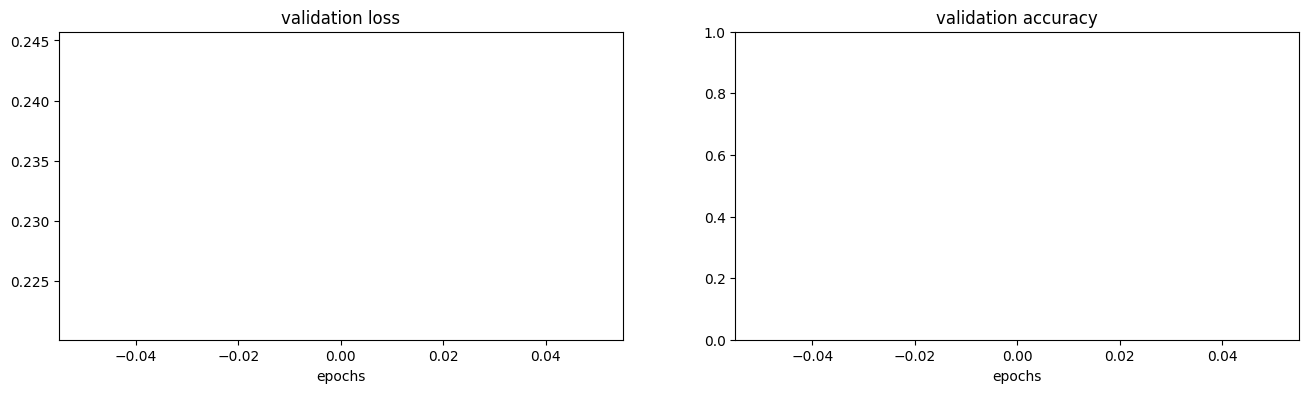

In [21]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
